In [1]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import re
from collections import defaultdict
from data.scorer import score_submission, print_confusion_matrix, score_defaults, SCORE_REPORT
from nltk import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm

# NOTE: Requires these following libraries:
# 'pip install matplotlib'  (Plotting)
# 'pip install numpy'  (Maths, Arrays/Matrices)
# 'pip install nltk'  (Pre-processing)
# 'pip install tqdm'  (Loading bars)

In [2]:
# Load training data from CSV
f_bodies = open('data/train_bodies.csv', 'r', encoding='utf-8')
csv_bodies = csv.DictReader(f_bodies)
bodies = []
for row in csv_bodies:
    body_id = int(row['Body ID'])
    if (body_id + 1) > len(bodies):
        bodies += [None] * (body_id + 1 - len(bodies))
    bodies[body_id] = row['articleBody']
f_bodies.close()
body_inverse_index = {bodies[i]: i for i in range(len(bodies))}

all_unrelated, all_discuss, all_agree, all_disagree = [], [], [], []  # each article = (headline, body, stance)

f_stances = open('data/train_stances.csv', 'r', encoding='utf-8')
csv_stances = csv.DictReader(f_stances)
for row in csv_stances:
    body = bodies[int(row['Body ID'])]
    if row['Stance'] == 'unrelated':
        all_unrelated.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'discuss':
        all_discuss.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'agree':
        all_agree.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'disagree':
        all_disagree.append((row['Headline'], body, row['Stance']))
f_stances.close()

In [3]:
# Split to train and validation 9:1
print('\tUnrltd\tDiscuss\t Agree\tDisagree')
print('All\t', len(all_unrelated), '\t', len(all_discuss), '\t', len(all_agree), '\t', len(all_disagree))

train_unrelated = all_unrelated[:len(all_unrelated) * 9 // 10]
train_discuss = all_discuss[:len(all_discuss) * 9 // 10]
train_agree = all_agree[:len(all_agree) * 9 // 10]
train_disagree = all_disagree[:len(all_disagree) * 9 // 10]

val_unrelated = all_unrelated[len(all_unrelated) * 9 // 10:]
val_discuss = all_discuss[len(all_discuss) * 9 // 10:]
val_agree = all_agree[len(all_agree) * 9 // 10:]
val_disagree = all_disagree[len(all_disagree) * 9 // 10:]

print('Train\t', len(train_unrelated), '\t', len(train_discuss), '\t', len(train_agree), '\t', len(train_disagree))
print('Valid.\t', len(val_unrelated), '\t', len(val_discuss), '\t', len(val_agree), '\t', len(val_disagree))

	Unrltd	Discuss	 Agree	Disagree
All	 36545 	 8909 	 3678 	 840
Train	 32890 	 8018 	 3310 	 756
Valid.	 3655 	 891 	 368 	 84


In [4]:
train_all = train_unrelated + train_discuss + train_agree + train_disagree  # each article = (headline, body, stance)
random.Random(0).shuffle(train_all)
train_all = np.array(train_all)

val_all = val_unrelated + val_discuss + val_agree + val_disagree
random.Random(0).shuffle(val_all)
val_all = np.array(val_all)

print('Train (Total)', train_all.shape, '\tValidation (Total)', val_all.shape)
print(np.count_nonzero(train_all[:, 2] == 'unrelated'), '\t',
      np.count_nonzero(train_all[:, 2] == 'discuss'), '\t',
      np.count_nonzero(train_all[:, 2] == 'agree'), '\t',
      np.count_nonzero(train_all[:, 2] == 'disagree'))
print(np.count_nonzero(val_all[:, 2] == 'unrelated'), '\t',
      np.count_nonzero(val_all[:, 2] == 'discuss'), '\t',
      np.count_nonzero(val_all[:, 2] == 'agree'), '\t',
      np.count_nonzero(val_all[:, 2] == 'disagree'))

Train (Total) (44974, 3) 	Validation (Total) (4998, 3)
32890 	 8018 	 3310 	 756
3655 	 891 	 368 	 84


In [5]:
# Tokenise text
pattern = re.compile("[^a-zA-Z0-9 ]+")  # strip punctuation, symbols, etc.
stop_words = set(stopwords.words('english'))
def tokenise(text):
    text = pattern.sub('', text.replace('\n', ' ').replace('-', ' ').lower())
    text = [word for word in word_tokenize(text) if word not in stop_words]
    return text

for i in range(9):
    print(train_all[i, 0], tokenise(train_all[i, 0]))

Al Qaida hostage killed in raid ['al', 'qaida', 'hostage', 'killed', 'raid']
UPDATE: Internet report of Ebola outbreak in Purdon not true ['update', 'internet', 'report', 'ebola', 'outbreak', 'purdon', 'true']
Christian Bale Won't Play Steve Jobs After All ['christian', 'bale', 'wont', 'play', 'steve', 'jobs']
#RIPFidel fuels false rumors of Cuban leader's death after another Fidel Castro dies ['ripfidel', 'fuels', 'false', 'rumors', 'cuban', 'leaders', 'death', 'another', 'fidel', 'castro', 'dies']
Boko Haram claims to have German hostage, denies ceasefire ['boko', 'haram', 'claims', 'german', 'hostage', 'denies', 'ceasefire']
Batmobile Stolen From 'Batman V Superman: Dawn Of Justice' Set? Report Claims That One Of The Batmobile Models Is Missing! Detroit Locals Responsible? ['batmobile', 'stolen', 'batman', 'v', 'superman', 'dawn', 'justice', 'set', 'report', 'claims', 'one', 'batmobile', 'models', 'missing', 'detroit', 'locals', 'responsible']
Report: ISIS kidnaps Canadian-Israeli, 

In [6]:
# Compute term-frequency of words in documents
def doc_to_tf(text, ngram=1):
    words = tokenise(text)
    ret = defaultdict(float)
    for i in range(len(words)):
        for j in range(1, ngram+1):
            if i - j < 0:
                break
            word = [words[i-k] for k in range(j)]
            ret[word[0] if ngram == 1 else tuple(word)] += 1.0
    return ret
    
for i in range(5):
    print(train_all[i, 0], doc_to_tf(train_all[i, 0]))
print(train_all[0, 0], doc_to_tf(train_all[0, 0], ngram=2))

Al Qaida hostage killed in raid defaultdict(<class 'float'>, {'qaida': 1.0, 'hostage': 1.0, 'killed': 1.0, 'raid': 1.0})
UPDATE: Internet report of Ebola outbreak in Purdon not true defaultdict(<class 'float'>, {'internet': 1.0, 'report': 1.0, 'ebola': 1.0, 'outbreak': 1.0, 'purdon': 1.0, 'true': 1.0})
Christian Bale Won't Play Steve Jobs After All defaultdict(<class 'float'>, {'bale': 1.0, 'wont': 1.0, 'play': 1.0, 'steve': 1.0, 'jobs': 1.0})
#RIPFidel fuels false rumors of Cuban leader's death after another Fidel Castro dies defaultdict(<class 'float'>, {'fuels': 1.0, 'false': 1.0, 'rumors': 1.0, 'cuban': 1.0, 'leaders': 1.0, 'death': 1.0, 'another': 1.0, 'fidel': 1.0, 'castro': 1.0, 'dies': 1.0})
Boko Haram claims to have German hostage, denies ceasefire defaultdict(<class 'float'>, {'haram': 1.0, 'claims': 1.0, 'german': 1.0, 'hostage': 1.0, 'denies': 1.0, 'ceasefire': 1.0})
Al Qaida hostage killed in raid defaultdict(<class 'float'>, {('qaida',): 1.0, ('hostage',): 1.0, ('hostage'

In [7]:
# Build corpus of article bodies and headlines in training dataset
corpus = np.r_[train_all[:, 1], train_all[:, 0]]  # 0 to 44973 are bodies, 44974 to 89943 are headlines

print(corpus[44974])
print(corpus[0])

Al Qaida hostage killed in raid
An attorney representing a man who says he realized he had inadvertently recorded audio of the Michael Brown shooting has provided that audio to CNN:

Attorney Lopa Blumenthal says the recording was made during a video chat. The audio captures what seem like 10 gunshot sounds—an initial group of six, then a pause, then four more. An autopsy of Brown's body performed at his family's request by an experienced forensic pathologist named Michael Baden indicated Brown was hit by at least six shots.

Eyewitness Dorian Johnson, a friend of Brown's, has said that officer Darren Wilson fired several shots at Brown after Brown had turned toward him and raised his hands. The Baden autopsy indicated that Brown had been shot exclusively in the front of his body.

Blumenthal says the man who made the recording has spoken to the FBI.

Read more on Ferguson.


In [8]:
# Learn idf of every word in the corpus
df = defaultdict(float)
for doc in tqdm(corpus):
    words = tokenise(doc)
    seen = set()
    for word in words:
        if word not in seen:
            df[word] += 1.0
            seen.add(word)

print(list(df.items())[:10])

100%|███████████████████████████████████████████████████████████████████████████| 89948/89948 [02:04<00:00, 722.62it/s]


[('attorney', 1738.0), ('representing', 417.0), ('man', 13433.0), ('says', 11259.0), ('realized', 518.0), ('inadvertently', 200.0), ('recorded', 2035.0), ('audio', 4122.0), ('michael', 6997.0), ('brown', 4232.0)]


In [9]:
num_docs = corpus.shape[0]
idf = defaultdict(float)
for word, val in tqdm(df.items()):
    idf[word] = np.log((1.0 + num_docs) / (1.0 + val)) + 1.0  # smoothed idf

print(list(idf.items())[:10])

100%|████████████████████████████████████████████████████████████████████████| 24433/24433 [00:00<00:00, 313249.06it/s]


[('attorney', 4.945932607675217), ('representing', 6.371516689504744), ('man', 2.90145403620269), ('says', 3.077986220335818), ('realized', 6.155094238863611), ('inadvertently', 7.103693213970424), ('recorded', 4.788255744359086), ('audio', 4.0826617893226), ('michael', 3.5536184491018665), ('brown', 4.0563318815085765)]


In [10]:
# Load GLoVe word vectors
f_glove = open("data/glove.6B.50d.txt", "rb")  # download from https://nlp.stanford.edu/projects/glove/
glove_vectors = {}
for line in tqdm(f_glove):
    glove_vectors[str(line.split()[0]).split("'")[1]] = np.array(list(map(float, line.split()[1:])))

print(glove_vectors['glove'])

400000it [00:11, 35282.84it/s]


[-1.2879   -0.14538  -0.016613  1.1387    1.1317    0.20705  -0.47351
  0.15898   0.67879   0.2382    0.11621   0.26053  -0.8379    1.1232
  0.31469  -0.47904  -0.33717  -0.34492  -0.72053  -1.0543   -0.58476
 -0.42184  -0.56977  -1.1697   -0.50389  -1.4706   -0.22005   1.1314
  1.0829   -1.5477    0.77931  -0.22865   0.33369   0.52067   0.22109
  1.1267    0.11704   1.1647    0.5875   -0.079243  0.022386  0.90118
 -0.37459   0.82637  -0.41061  -0.95039   0.44121  -0.58558   0.12594
 -0.71778 ]


In [11]:
# Convert a document to GloVe vectors, by computing tf-idf of each word * GLoVe of word / total tf-idf for document
def doc_to_glove(doc):
    doc_tf = doc_to_tf(doc)
    doc_tf_idf = defaultdict(float)
    for word, tf in doc_tf.items():
        doc_tf_idf[word] = tf * idf[word]
        
    doc_vector = np.zeros(glove_vectors['glove'].shape[0])
    if np.sum(list(doc_tf_idf.values())) == 0.0:  # edge case: document is empty
        return doc_vector
    
    for word, tf_idf in doc_tf_idf.items():
        if word in glove_vectors:
            doc_vector += glove_vectors[word] * tf_idf
    doc_vector /= np.sum(list(doc_tf_idf.values()))
    return doc_vector

for i in range(2):
    print(train_all[i, 0], doc_to_glove(train_all[i, 0]))

Al Qaida hostage killed in raid [ 1.55523383 -0.53210908  0.76620923 -0.21431609  0.629703   -0.32006548
 -0.31970142  0.73942066  0.15429804 -0.21196605 -0.46515589 -0.82212054
 -0.5307356   0.4230665   0.00401337 -0.56455499 -0.30577957 -0.16831217
 -0.68347781  1.09527072 -0.04144157  0.81056322  0.51446038  0.29237717
 -0.74519525 -1.76758745 -0.33135205 -0.44939975  0.37342411  0.23482803
  1.81228505 -0.49575286 -0.64458321 -0.3668451   0.67194757  0.34778443
 -0.12845981 -1.08455272 -0.62624605  0.3107455  -0.42629639  0.23873348
  0.47901684 -0.54188893  1.07257085 -0.47847246 -0.57972412  0.241845
  0.02628177 -0.38890417]
UPDATE: Internet report of Ebola outbreak in Purdon not true [ 0.70455934 -0.38734665  0.06858393 -0.07319071 -0.14090453  0.17829662
 -0.1488975  -0.31604903  0.94739613 -0.13496243  0.06521208 -0.07735578
  0.03351917 -0.41814123  0.50764665 -0.02230575 -0.34579725 -0.21483033
 -0.19021705  0.43873857 -0.47030045 -0.22234839  0.48524512  0.26016291
  0.379

In [12]:
# Compute cosine similarity of GLoVe vectors for all headline-body pairs
def dot_product(vec1, vec2):
    sigma = 0.0
    for i in range(vec1.shape[0]):  # assume vec1 and vec2 has same shape
        sigma += vec1[i] * vec2[i]
    return sigma
    
def magnitude(vec):
    return np.sqrt(np.sum(np.square(vec)))
        
def cosine_similarity(doc):
    headline_vector = doc_to_glove(doc[0])
    body_vector = doc_to_glove(doc[1])
    
    if magnitude(headline_vector) == 0.0 or magnitude(body_vector) == 0.0:  # edge case: document is empty
        return 0.0
    
    return dot_product(headline_vector, body_vector) / (magnitude(headline_vector) * magnitude(body_vector))

for i in range(10):
    # unrelated should have lower than rest
    print(cosine_similarity(train_all[i]), train_all[i, 2])
print(cosine_similarity(train_all[27069]), tokenise(train_all[27069, 0]), tokenise(train_all[27069, 1]))  # edge case

0.5636440560517227 unrelated
0.5164733208676751 unrelated
0.6760296124466074 unrelated
0.767126913562204 unrelated
0.752183433877146 unrelated
0.8795186723871924 discuss
0.5023472347134285 unrelated
0.8030319138667993 unrelated
0.6109934087057954 unrelated
0.6277450807506688 discuss
0.0 ['tips', 'chinese', 'choosing', 'english', 'name'] ['cctvnewscn']


In [13]:
# Compute the KL-Divergence of language model (LM) representations of the headline and the body
def divergence(lm1, lm2):
    sigma = 0.0
    for i in range(lm1.shape[0]):  # assume lm1 and lm2 has same shape
        sigma += lm1[i] * np.log(lm1[i] / lm2[i])
    return sigma

def kl_divergence(doc, eps=0.1):
    # Convert headline and body to 1-gram representations
    tf_headline = doc_to_tf(doc[0])
    tf_body = doc_to_tf(doc[1])
    
    # Convert dictionary tf representations to vectors (make sure columns match to the same word)
    words = set(tf_headline.keys()).union(set(tf_body.keys()))
    vec_headline, vec_body = np.zeros(len(words)), np.zeros(len(words))
    i = 0
    for word in words:
        vec_headline[i] += tf_headline[word]
        vec_body[i] = tf_body[word]
        i += 1
    
    # Compute a simple 1-gram language model of headline and body
    lm_headline = vec_headline + eps
    lm_headline /= np.sum(lm_headline)
    lm_body = vec_body + eps
    lm_body /= np.sum(lm_body)
    
    # Return KL-divergence of both language models
    return divergence(lm_headline, lm_body)

for i in range(10):
    # unrelated should have higher than rest
    print(kl_divergence(train_all[i]), train_all[i, 2])
print(kl_divergence(train_all[27069]), tokenise(train_all[27069, 0]), tokenise(train_all[27069, 1]))  # edge case

1.551801163955211 unrelated
1.3669217307956298 unrelated
1.179981357622393 unrelated
1.808940496290798 unrelated
0.9196569536756409 unrelated
1.8322388786374553 discuss
2.001011743642174 unrelated
2.3189273862983426 unrelated
2.3270414360137206 unrelated
0.6219721313795342 discuss
0.0 ['tips', 'chinese', 'choosing', 'english', 'name'] ['cctvnewscn']


In [14]:
# Other feature 1
def ngram_overlap(doc):
    # Returns how many times n-grams (up to 3-gram) that occur in the article's headline occur on the article's body.
    tf_headline = doc_to_tf(doc[0], ngram=3)
    tf_body = doc_to_tf(doc[1], ngram=3)
    matches = 0.0
    for words in tf_headline.keys():
        if words in tf_body:
            matches += tf_body[words]
    return np.power((matches / len(tokenise(doc[1]))), 1 / np.e)  # normalise for document length

for i in range(10):
    # unrelated should have lower than rest
    print(ngram_overlap(train_all[i]), train_all[i, 2])

0.0 unrelated
0.0 unrelated
0.0 unrelated
0.0 unrelated
0.12857060888583305 unrelated
0.42424795135754484 discuss
0.0 unrelated
0.0 unrelated
0.0 unrelated
0.25717937945613284 discuss


In [15]:
# Define function to convert (headline, body) to feature vectors for each document
ftrs = [cosine_similarity, kl_divergence, ngram_overlap]
def to_feature_array(doc):
    vec = np.array([0.0] * len(ftrs))
    for i in range(len(ftrs)):
        vec[i] = ftrs[i](doc)
    return vec

# Initialise X (matrix of feature vectors) for train dataset
x_train = np.array([to_feature_array(doc) for doc in tqdm(train_all)])
print(x_train[:10])

100%|████████████████████████████████████████████████████████████████████████████| 44974/44974 [10:04<00:00, 74.43it/s]


[[0.56364406 1.55180116 0.        ]
 [0.51647332 1.36692173 0.        ]
 [0.67602961 1.17998136 0.        ]
 [0.76712691 1.8089405  0.        ]
 [0.75218343 0.91965695 0.12857061]
 [0.87951867 1.83223888 0.42424795]
 [0.50234723 2.00101174 0.        ]
 [0.80303191 2.31892739 0.        ]
 [0.61099341 2.32704144 0.        ]
 [0.62774508 0.62197213 0.25717938]]


In [16]:
# Define label <-> int mappings for y
label_to_int = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
int_to_label = ['agree', 'disagree', 'discuss', 'unrelated']

# Initialise Y (gold output vector) for train dataset
y_train = np.array([label_to_int[i] for i in train_all[:, 2]])
print(y_train[:10])

[3 3 3 3 3 2 3 3 3 2]


In [17]:
# Check integrity of X and Y
print(np.where(np.isnan(x_train)))
print(np.where(np.isfinite(x_train) == False))
print(x_train.shape)
print(y_train.shape)  # x_train.shape[0] == y_train.shape[0]

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(44974, 3)
(44974,)


[('g', 'agree'), ('r', 'disagree'), ('b', 'discuss'), ('y', 'unrelated')]


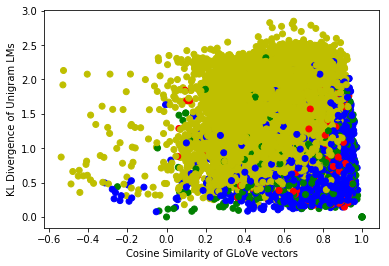

In [18]:
# Plot GLoVe distance vs KL-Divergence on a coloured scatter plot with different colours for each label
colours = np.array(['g', 'r', 'b', 'y'])
plt.scatter(list(x_train[:, 0]), list(x_train[:, 1]), c=colours[y_train])
plt.xlabel('Cosine Similarity of GLoVe vectors')
plt.ylabel('KL Divergence of Unigram LMs')
print([(colours[i], int_to_label[i]) for i in range(len(int_to_label))])
plt.show()

In [19]:
# Initialise x (feature vectors) for validation dataset
x_val = np.array([to_feature_array(doc) for doc in tqdm(val_all)])
print(x_val[:5])

100%|██████████████████████████████████████████████████████████████████████████████| 4998/4998 [01:12<00:00, 68.50it/s]


[[0.24025197 1.16097222 0.        ]
 [0.89403671 0.55129714 0.53773387]
 [0.78941201 0.93792956 0.        ]
 [0.75226095 1.17694873 0.14567468]
 [0.68675047 1.87787208 0.        ]]


In [20]:
# Linear regression model
def mse(pred, gold):
    sigma = 0.0
    for i in range(pred.shape[0]):
        sigma += np.square(pred[i] - gold[i])
    return sigma / (2 * pred.shape[0])

print(mse(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0]), np.array([0, 0, 0, 1, 1, 1])))

0.04833333333333334


In [21]:
class LinearRegression:
    
    def __init__(self, lrn_rate, n_iter):
        self.lrn_rate = lrn_rate
        self.n_iter = n_iter
        # self.breakpoints = set([n_iter * i // 10 for i in range(1, 11)])
        
    def fit(self, X, Y):
        # Learn a model y = intercept + x0*t0 + x1*t1 + x2*t2 + ... that minimises MSE. Need to optimise T
        # self.intercept = 0.0
        self.model = np.zeros(X.shape[1])  # model[0] = t0, model[1] = t1, etc.
        for it in tqdm(range(self.n_iter)):
            model_Y = self.transform(X)
            # Thetas
            for col in range(X.shape[1]):
                s = 0.0
                for row in range(X.shape[0]):
                    s += (model_Y[row] - Y[row]) * X[row, col]
                self.model[col] -= self.lrn_rate * s / X.shape[0]
            # Intercept
            # s_int = 0.0
            # for row in range(X.shape[0]):
            #     s_int += (model_Y[row] - Y[row]) * 1.0
            # self.intercept -= self.lrn_rate * s_int / X.shape[0]
            # if it + 1 in self.breakpoints:
                # print('Iteration', it+1, 'MSE:', mse(model_Y, Y))
        print('Final MSE:', mse(model_Y, Y))
        # print('Intercept:', self.intercept)
        print('Model:', self.model)
        
    def transform(self, X):
        # Returns a float value for each X. (Regression)
        Y = np.zeros(X.shape[0])
        for row in range(X.shape[0]):
            # s = self.intercept
            s = 0.0
            for col in range(X.shape[1]):
                s += self.model[col] * X[row, col]
            Y[row] = s
        return Y
    
    def predict(self, X):
        # Uses results of transform() for binary classification. For testing only, use OneVAllClassifier for the final run.
        Y = self.transform(X)
        Y = np.array([(1 if i > 0.5 else 0) for i in Y])
        return Y

# Test only
# lr = LinearRegression(lrn_rate=0.1, n_iter=100)
# lr.fit(x_train[:1000], np.array([(1 if i == 3 else 0) for i in y_train[:1000]]))
# print(lr.transform(x_train[1000:1020]))
# print('Predicted', lr.predict(x_train[1000:1020]))
# print('Actual', np.array([(1 if i == 3 else 0) for i in y_train[1000:1020]]))

In [22]:
# Logistic regression functions
def sigmoid(Y):
    return 1 / (1 + np.exp(Y * -1))

print(sigmoid(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0])))

def logistic_cost(pred, gold):
    sigma = 0.0
    for i in range(pred.shape[0]):
        if gold[i] == 1:  
            sigma -= np.log(pred[i])
        elif gold[i] == 0:
            sigma -= np.log(1 - pred[i])
    return sigma / pred.shape[0]

print(mse(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0]), np.array([0, 0, 0, 1, 1, 1])))
print(logistic_cost(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0]), np.array([0, 0, 0, 1, 1, 1])))
print(logistic_cost(sigmoid(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0])), np.array([0, 0, 0, 1, 1, 1])))

[0.5        0.549834   0.62245933 0.62245933 0.68997448 0.73105858]
0.04833333333333334
0.3054302439580517
0.6039670619612919


In [23]:
# Logistic regression model
class LogisticRegression:
    
    def __init__(self, lrn_rate, n_iter):
        self.lrn_rate = lrn_rate
        self.n_iter = n_iter
        # self.breakpoints = set([n_iter * i // 10 for i in range(1, 11)])
        
    def fit(self, X, Y):
        # Learn a model y = x0*t0 + x1*t1 + x2*t2 + ... that minimises MSE. Need to optimise T
        self.model = np.zeros(X.shape[1])  # model[0] = t0, model[1] = t1, etc.
        for it in tqdm(range(self.n_iter)):
            model_Y = self.transform(X)
            for col in range(X.shape[1]):
                s = 0.0
                for row in range(X.shape[0]):
                    s += (model_Y[row] - Y[row]) * X[row, col]
                self.model[col] -= self.lrn_rate * s / X.shape[0]
            # if it + 1 in self.breakpoints:
                # print('Iteration', it+1, 'loss:', logistic_cost(model_Y, Y))
        print('Final loss:', logistic_cost(model_Y, Y))
        print('Model:', self.model)
        
    def transform(self, X):
        # Returns a float value for each X. (Regression)
        Y = np.zeros(X.shape[0])
        for row in range(X.shape[0]):
            s = 0.0
            for col in range(X.shape[1]):
                s += self.model[col] * X[row, col]
            Y[row] = s
        return sigmoid(Y)
    
    def predict(self, X):
        # Uses results of transform() for binary classification. For testing only, use OneVAllClassifier for the final run.
        Y = self.transform(X)
        Y = np.array([(1 if i > 0.5 else 0) for i in Y])
        return Y

# Test only
# lr = LogisticRegression(lrn_rate=0.1, n_iter=100)
# lr.fit(x_train[:1000], np.array([(1 if i == 3 else 0) for i in y_train[:1000]]))
# print(lr.transform(x_train[1000:1020]))
# print('Predicted', lr.predict(x_train[1000:1020]))
# print('Actual', np.array([(1 if i == 3 else 0) for i in y_train[1000:1020]]))

In [24]:
# To use linear/logistic regression models to classify multiple classes
class OneVAllClassifier:
    
    def __init__(self, regression, **params):
        self.regression = regression
        self.params = params
        
    def fit(self, X, Y):
        # Learn a model for each parameter.
        self.categories = np.unique(Y)
        self.models = {}
        for cat in self.categories:
            ova_Y = np.array([(1 if i == cat else 0) for i in Y])
            model = self.regression(**self.params)
            model.fit(X, ova_Y)
            self.models[cat] = model
            print(int_to_label[cat])
    
    def predict(self, X):
        # Predicts each x for each different model learned, and returns the category related to the model with the highest score.
        vals = {}
        for cat, model in self.models.items():
            vals[cat] = model.transform(X)
        Y = np.zeros(X.shape[0], dtype=np.int)
        for row in range(X.shape[0]):
            max_val, max_cat = -math.inf, -math.inf
            for cat, val in vals.items():
                if val[row] > max_val:
                    max_val, max_cat = val[row], cat
            Y[row] = max_cat
        return Y
    
# Test only
# ova = OneVAllClassifier(LinearRegression, lrn_rate=0.1, n_iter=100)
# ova.fit(x_train[:1000], y_train[:1000])
# print('Predicted', ova.predict(x_train[1000:1020]))
# print('Actual', y_train[1000:1020])

In [25]:
# Train the linear regression & One-V-All classifier models on the train set
clf = OneVAllClassifier(LinearRegression, lrn_rate=0.1, n_iter=1000)
clf.fit(x_train, y_train)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:30<00:00,  4.76it/s]


Final MSE: 0.02908818979879915
Model: [ 0.06230136 -0.02892398  0.44871666]
agree


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:17<00:00,  5.05it/s]


Final MSE: 0.008033005315349694
Model: [ 0.02016641 -0.00838331  0.09061424]
disagree


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:12<00:00,  5.19it/s]


Final MSE: 0.04281122958369169
Model: [ 0.29537823 -0.12932566  0.94972588]
discuss


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:19<00:00,  5.02it/s]


Final MSE: 0.04277236057478231
Model: [ 0.56418649  0.4055448  -1.3705838 ]
unrelated


In [26]:
# Predict y for validation set
y_pred = clf.predict(x_val)
print(y_pred[:5])
predicted = np.array([int_to_label[i] for i in y_pred])
print(predicted[:5])
print(val_all[:, 2][:5])

[3 2 3 3 3]
['unrelated' 'discuss' 'unrelated' 'unrelated' 'unrelated']
['unrelated' 'agree' 'unrelated' 'unrelated' 'unrelated']


In [27]:
# Prepare validation dataset format for score_submission in scorer.py
body_ids = [str(body_inverse_index[body]) for body in val_all[:, 1]]
pred_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': predicted[i]} for i in range(len(val_all))])
gold_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': val_all[i, 2]} for i in range(len(val_all))])

In [28]:
# Score using scorer.py (provided in https://github.com/FakeNewsChallenge/fnc-1) on VALIDATION set:
test_score, cm = score_submission(gold_for_cm, pred_for_cm)
null_score, max_score = score_defaults(gold_for_cm)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    302    |    66     |
-------------------------------------------------------------
| disagree  |     0     |     0     |    65     |    19     |
-------------------------------------------------------------
|  discuss  |     1     |     0     |    741    |    149    |
-------------------------------------------------------------
| unrelated |     0     |     1     |    46     |   3608    |
-------------------------------------------------------------
ACCURACY: 0.870

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||  2256.75  ||  913.75   ||  1735.0   ||



In [29]:
# Predict y for validation set using logistic regression instead of linear regression, and compare results of scorer.py
clf_logistic = OneVAllClassifier(LogisticRegression, lrn_rate=0.1, n_iter=1000)
clf_logistic.fit(x_train, y_train)

y_pred = clf_logistic.predict(x_val)
predicted = np.array([int_to_label[i] for i in y_pred])

body_ids = [str(body_inverse_index[body]) for body in val_all[:, 1]]
pred_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': predicted[i]} for i in range(len(val_all))])
gold_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': val_all[i, 2]} for i in range(len(val_all))])

test_score, cm = score_submission(gold_for_cm, pred_for_cm)
null_score, max_score = score_defaults(gold_for_cm)
print()
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))
# linear regression performs better, so that model is chosen for the test set

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:24<00:00,  4.89it/s]


Final loss: 0.22604783942716677
Model: [-0.60290899 -2.09889147  0.91520547]
agree


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:27<00:00,  4.82it/s]


Final loss: 0.08359489774556864
Model: [-1.64130089 -2.64682942 -0.24056022]
disagree


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:21<00:00,  4.95it/s]


Final loss: 0.2991535532390866
Model: [ 0.87164859 -2.3937786   2.39670896]
discuss


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:24<00:00,  4.88it/s]


Final loss: 0.25937043615214894
Model: [-1.74466873  2.57339594 -3.72173094]
unrelated

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    236    |    132    |
-------------------------------------------------------------
| disagree  |     0     |     0     |    49     |    35     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    609    |    282    |
-------------------------------------------------------------
| unrelated |     0     |     0     |    47     |   3608    |
-------------------------------------------------------------
ACCURACY: 0.844

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||

In [30]:
# Load test data from CSV
f_tbodies = open('data/competition_test_bodies.csv', 'r', encoding='utf-8')
csv_tbodies = csv.DictReader(f_tbodies)
tbodies = []
for row in csv_tbodies:
    body_id = int(row['Body ID'])
    if (body_id + 1) > len(tbodies):
        tbodies += [None] * (body_id + 1 - len(tbodies))
    tbodies[body_id] = row['articleBody']
f_tbodies.close()
tbody_inverse_index = {tbodies[i]: i for i in range(len(tbodies))}

test_all = []  # each article = (headline, body, stance)

f_tstances = open('data/competition_test_stances.csv', 'r', encoding='utf-8')
csv_tstances = csv.DictReader(f_tstances)
for row in csv_tstances:
    body = tbodies[int(row['Body ID'])]
    test_all.append((row['Headline'], body, row['Stance']))
f_tstances.close()

# test_all = np.array(test_all)  # for some reason gives MemoryError
# print(test_all.shape)

In [31]:
# Initialise x (feature vectors) and y for test dataset
x_test = np.array([to_feature_array(doc) for doc in tqdm(test_all)])
print(x_test[:5])

100%|████████████████████████████████████████████████████████████████████████████| 25413/25413 [04:39<00:00, 91.01it/s]


[[0.78681984 1.84940367 0.        ]
 [0.43540726 1.50340396 0.        ]
 [0.59061399 1.32746514 0.14596078]
 [0.55240418 1.17096374 0.        ]
 [0.72740017 2.1493695  0.        ]]


In [32]:
# Predict y for test set
y_test = clf.predict(x_test)
print(y_pred[:5])
pred_test = np.array([int_to_label[i] for i in y_test])
print(pred_test[:5])

[3 2 3 3 3]
['unrelated' 'unrelated' 'unrelated' 'unrelated' 'unrelated']


In [33]:
# Prepare test dataset format for score_submission in scorer.py
test_body_ids = [str(tbody_inverse_index[test_all[i][1]]) for i in range(len(test_all))]
test_pred_for_cm = np.array([{'Headline': test_all[i][0], 'Body ID': test_body_ids[i], 'Stance': pred_test[i]} for i in range(len(test_all))])
test_gold_for_cm = np.array([{'Headline': test_all[i][0], 'Body ID': test_body_ids[i], 'Stance': test_all[i][2]} for i in range(len(test_all))])

In [34]:
# Score using scorer.py (provided in https://github.com/FakeNewsChallenge/fnc-1) on TEST set:
test_score, cm = score_submission(test_gold_for_cm, test_pred_for_cm)
null_score, max_score = score_defaults(test_gold_for_cm)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |   1504    |    399    |
-------------------------------------------------------------
| disagree  |     0     |     0     |    433    |    264    |
-------------------------------------------------------------
|  discuss  |     0     |     0     |   3417    |   1047    |
-------------------------------------------------------------
| unrelated |     1     |     0     |    160    |   18188   |
-------------------------------------------------------------
ACCURACY: 0.850

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  8448.25  ||

